In [1]:
# autoreload libraries
%load_ext autoreload
%autoreload 2

import pandas as pd
import warnings

import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import numpy as np
import folium
from folium.map import Element
import seaborn as sns
from IPython.display import Markdown as md
from IPython.display import display, HTML

from nycschools import schools, geo, ui, config

import xyzservices.providers as xyz


warnings.filterwarnings('ignore')

# Print the list of available tile providers
# tile_providers = xyz.flatten()
# for provider_name in tile_providers:
#     print(provider_name)


In [2]:
# load all of the data and clean it up
loc = geo.load_school_locations()
districts = geo.load_districts()
df = schools.load_school_demographics()

df = df[df.ay == df.ay.max()]


# merge school locations and demographics
# get only the demo columns that aren't in locations already
cols = ["dbn"] + list(set(df.columns) - set(loc.columns))
data = loc.merge(df[cols], on="dbn", how="inner")


feet = geo.load_school_footprints()

In [3]:
# find the middle of all of the school points
centroids = loc.geometry.centroid
lat = centroids.y.mean()
lon = centroids.x.mean()
m = folium.Map(location=[lat, lon], zoom_start=12, tiles=xyz.CartoDB.PositronNoLabels.build_url(), attr="cartodb")

# make a layer for each decade
loc['layer'] = loc.open_date // 10 * 10

decades = sorted(loc['layer'].unique())
colors = sns.color_palette("tab20", len(decades)).as_hex()
legend = dict(zip(decades, colors))
loc["color"] = loc['layer'].map(legend)

legend = [(f"{y}-{y+9} ({ len(loc[loc.layer == y]) } schools)", c, y) for y,c in legend.items()]
legend[0] = (f"Unknown ({ len(loc[loc.layer == 0]) } schools)", legend[0][1], 0)
m = ui.map_layers(m, loc)
m = ui.map_legend(m, legend, title="School Openings 1860-2020")
m.save("colac.html")
m


Public Schools in NYC
====================
Our data, current to 2022 shows 1890 public schools in NYC.


,School Type,Number of Schools
1,Community Schools,"1,545"
0,Charter Schools,276
2,District 75 (SWD),61
3,Transfer Schools,8
0,Total,"1,890"


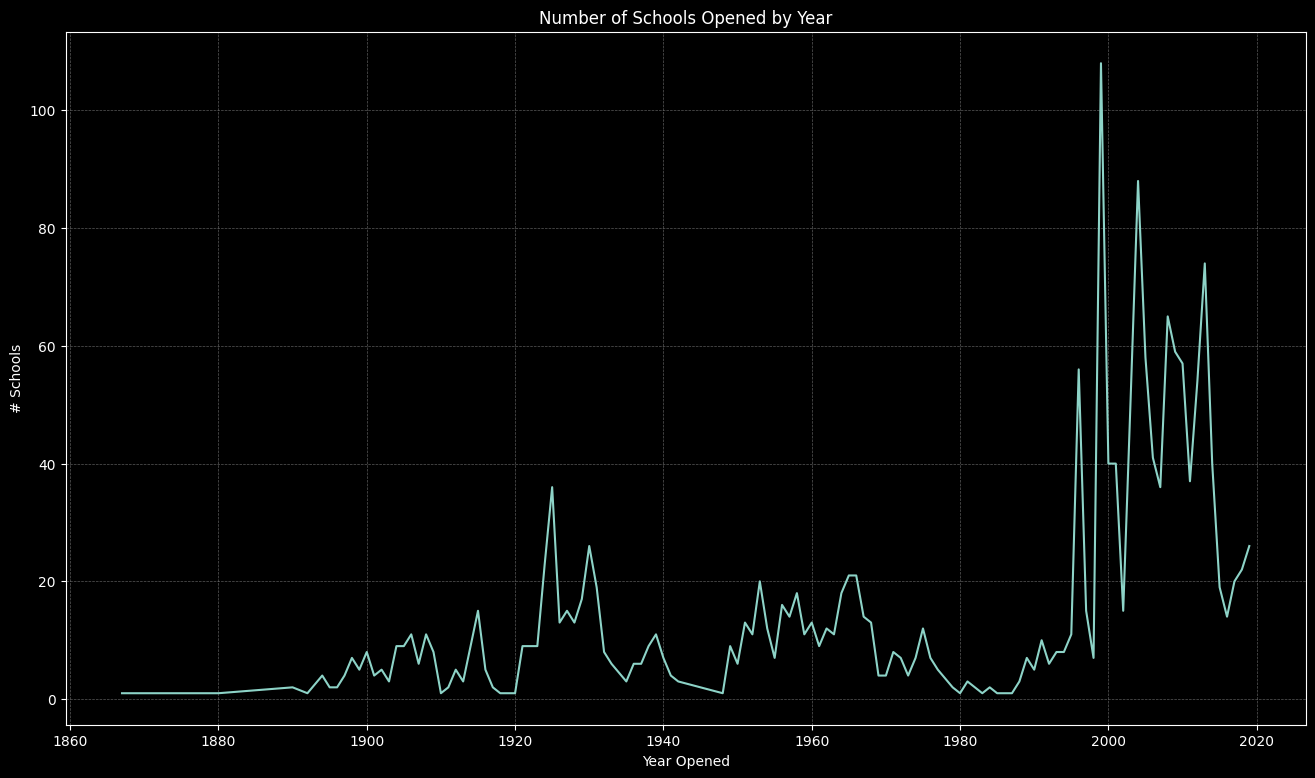


Charter Schools
---------------
The first charter school opened in NYC in 1999.


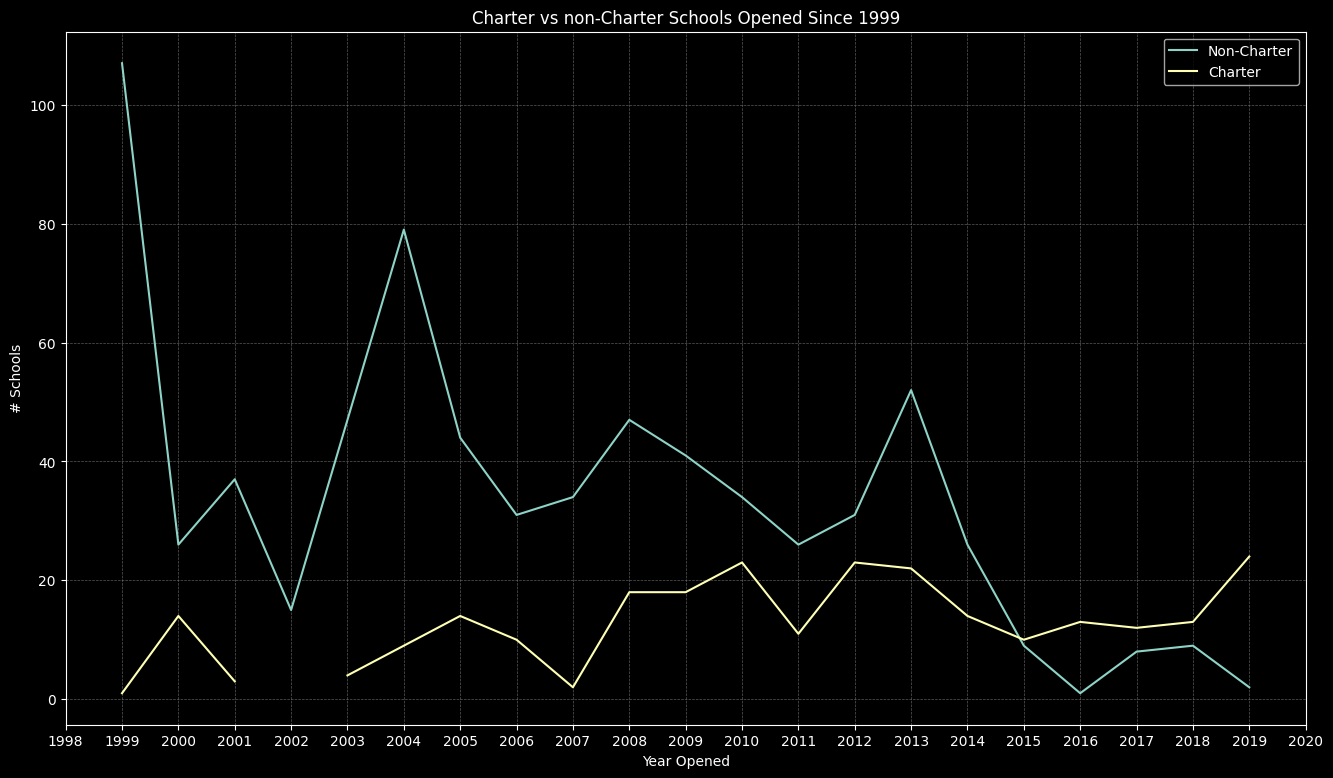

In [4]:
def school_type(district):
    if district == 84:
        return "Charter Schools"
    elif district == 79:
        return "Transfer Schools"
    elif district == 75:
        return "District 75 (SWD)"
    
    return "Community Schools"

df["school_type"] = df.district.apply(school_type)
school_counts = pd.DataFrame(df.groupby("school_type").dbn.count()).reset_index()
school_counts.sort_values("dbn", ascending=False, inplace=True)
school_counts.columns = ["School Type", "Number of Schools"]
school_counts = pd.concat([school_counts, pd.DataFrame(["Total", school_counts["Number of Schools"].sum()], index=["School Type", "Number of Schools"]).T])
school_counts = ui.fmt_table(school_counts,num_cols=["Number of Schools"])



open_year = loc.copy()
open_year["charter"] = open_year.district == 84

plt.style.use("dark_background")
ax = open_year[open_year.open_date > 0].groupby(["open_date"]).dbn.count().plot(figsize=(16,9))
ax.set_title("Number of Schools Opened by Year")
ax.set_ylabel("# Schools")
ax.set_xlabel("Year Opened")
ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.7)


ui.show_md(f"""
Public Schools in NYC
====================
Our data, current to 2022 shows {df.dbn.nunique()} public schools in NYC.
""")


display(school_counts)
plt.show()

ui.show_md(f"""
Charter Schools
---------------
The first charter school opened in NYC in {open_year[open_year.charter].open_date.min()}.
""")

ax = open_year[open_year.open_date > 1998].groupby(["open_date", "charter"]).dbn.count().unstack().plot(figsize=(16,9))
ax.set_title("Charter vs non-Charter Schools Opened Since 1999")
ax.set_ylabel("# Schools")
ax.set_xlabel("Year Opened")
ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
years = np.arange(1998, 2021)
ax.set_xticks(years)
ax.set_xticklabels(years)
ax.legend(["Non-Charter", "Charter"])
plt.show()